# Structure Relations


## Setup

### Imports

In [1]:
# Type imports
from typing import Any, Dict, Tuple

# Standard Libraries
from pathlib import Path
from itertools import combinations
from math import sqrt, pi
import re
from statistics import mean
from pprint import pprint

# Shared Packages
import numpy as np
import pandas as pd
import xlwings as xw
import PySimpleGUI as sg
import pydicom
from shapely.geometry import Polygon
from shapely import points
import shapely

import RS_DICOM_Utilities


### Global Settings

In [2]:
PRECISION = 3


### Utility Functions

In [3]:
# Load Table
def load_table(file_name: Path, sheet_name: str, options: Dict[str, Any])->Any:
    '''Get a data collection from a spreadsheet.

    Returns the data found starting in the upper left cell of the spreadsheet.

    Args:
        file_name (Path): Path to the workbook.
        sheet_name (str): Name of the sheet in the workbook
        options (Dict[str, Any]): Converter options for teh data.

    Returns:
        Any: The data from the spreadsheet in the format dictated by the
            options.
    '''
    with xw.App() as app:
        book = app.books.open(file_name)

        range1 = book.sheets[sheet_name].range('A1').expand()
        data = range1.options(**options).value
    return data

## DE-9IM Relationships
[DE-9IM](https://en.wikipedia.org/wiki/DE-9IM)


The DE-9IM model is based on a 3×3 intersection matrix with the form:

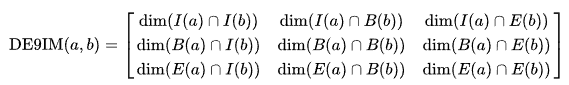

where 
_dim_ is the dimension of the intersection (∩) of the interior (I), boundary (B), and exterior (E) of geometries a and b.

Visually, for two overlapping polygonal geometries, the result of the function DE_9IM(a,b) looks like:

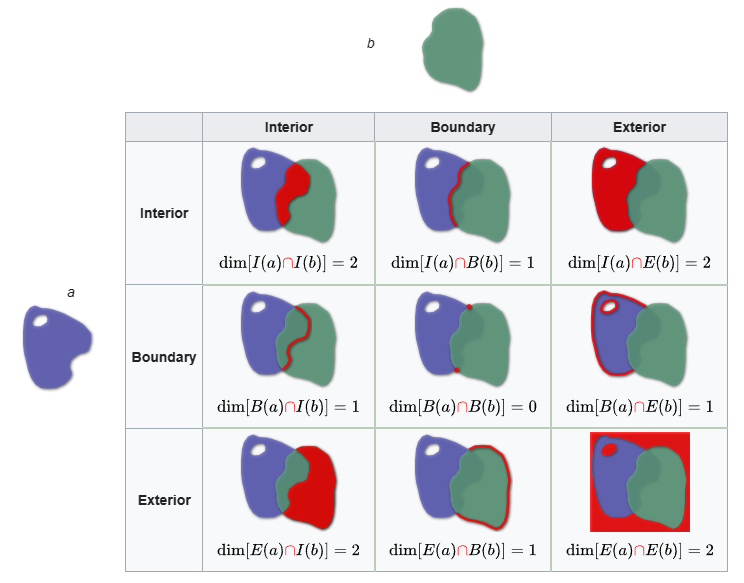


This matrix can be serialized. Reading from left-to-right and top-to-bottom, the result is



 So, in a compact representation as string code is '212101212'.

### Defined Relationships
The relationships of interest for DICOM structures are:

<table>
<thead>
  <tr>
    <th>Name</th>
    <th>Intersection Matrix</th>
    <th>mask code string</th>
    <th>Meaning and definition</th>
    <th>Equivalent</th>    
  </tr>
</thead>
<tbody>


  <tr><td>Disjoint</td><td>

$\begin{smallmatrix} 
    \mathrm {F} &\mathrm {F} &\mathrm {*} 
  \\\mathrm {F} &\mathrm {F} &\mathrm {*} 
  \\\mathrm {*} &\mathrm {*} &\mathrm {*} 
  \end{smallmatrix}$
</td>
<td>FF*FF****</td>
<td>a and b have no points in common.</td>
<td>not Intersects</td>
</tr>


<tr><td>Borders</td><td>

$\begin{smallmatrix}  
    \mathrm {F} &\mathrm {F} &\mathrm {*} 
  \\\mathrm {F} &\mathrm {1} &\mathrm {*} 
  \\\mathrm {*} &\mathrm {*} &\mathrm {*} 
\end{smallmatrix}$
</td>
<td>FF*F1****</td>
<td>The boundaries of a and b have more than one point in common, but their 
    interiors do not intersect.</td>
<td></td>
</tr>


<tr><td>Overlaps</td><td>

$\begin{smallmatrix}  
    \mathrm {2} &\mathrm {*} &\mathrm {2} 
  \\\mathrm {*} &\mathrm {*} &\mathrm {*} 
  \\\mathrm {2} &\mathrm {*} &\mathrm {*} 
\end{smallmatrix}$  
</td>
<td>2*2***2**</td>
<td>a and b have some but not all points in common.</td>
<td></td></tr>


<tr><td>Equals</td><td>

$\begin{smallmatrix}  
    \mathrm {2} &\mathrm {*} &\mathrm {F} 
  \\\mathrm {*} &\mathrm {*} &\mathrm {F} 
  \\\mathrm {F} &\mathrm {F} &\mathrm {*} 
\end{smallmatrix}$  
</td>
<td>2*F**FFF*</td>
<td>The interiors of a and b intersect and no part of the interior or boundary 
    of one geometry intersects the exterior of the other.</td>
<td>Within &amp; Contains</td>
</tr>


<tr><td>Delimits</td><td>

$\begin{smallmatrix}  
    \mathrm {2} &\mathrm {*} &\mathrm {F} 
  \\\mathrm {*} &\mathrm {1} &\mathrm {F} 
  \\\mathrm {*} &\mathrm {*} &\mathrm {*} 
\end{smallmatrix}$  
</td>
<td>2*F*1F***</td>
<td>The boundaries of a and b have more than one point in common, and a lies 
    in the interior of b.</td>
<td>Encompasses(b,a)</td>
</tr>


<tr><td>Encompasses</td><td>

$\begin{smallmatrix}  
    \mathrm {2} &\mathrm {*} &\mathrm {*} 
  \\\mathrm {*} &\mathrm {1} &\mathrm {*} 
  \\\mathrm {F} &\mathrm {F} &\mathrm {*} 
\end{smallmatrix}$  
</td>
<td>2***1*FF*</td>
<td>The boundaries of a and b have more than one point in common, and b lies 
    in the interior of a.</td>
<td>Delimits(b,a)</td>


<tr><td>Within</td><td>

$\begin{smallmatrix}  
    \mathrm {2} &\mathrm {*} &\mathrm {F} 
  \\\mathrm {*} &\mathrm {*} &\mathrm {F} 
  \\\mathrm {*} &\mathrm {*} &\mathrm {*} 
\end{smallmatrix}$  
<td>2*F**F***</td>
<td>a lies in the interior of b.</td>
<td>Contains(b,a)</td>
</tr>


<tr><td>Contains</td><td>

$\begin{smallmatrix}  
    \mathrm {2} &\mathrm {*} &\mathrm {*} 
  \\\mathrm {*} &\mathrm {*} &\mathrm {*} 
  \\\mathrm {F} &\mathrm {F} &\mathrm {*} 
\end{smallmatrix}$  
</td>
<td>2*****FF*</td>
<td>No points of b lies in the exterior of a, and some of the the points of 
    the interior of b lie in the interior of a.</td>
<td>Within(b,a)</td>
</tr>

</table>



### Objects with holes
There is one additional relationship to be captured:

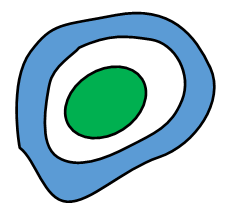

**Surrounds**

When the exterior of shape $a$ completely *covers* shape $b$, but does not 
*contain* it, then shape $a$ *surrounds* $b$.  

This will be identified by adding a second *DE-9IM* sequence describing the 
relationship between shape $a$ and shape $b$ after filling all holes in 
both shapes.  If this sequence matches a _contains_ relation then 
$a$ *surrounds* $b$.  If this sequence matches a _within_ relation then 
$a$ *embeds* $b$.



Those relationships can be identified using regular expressions:

In [4]:
def relation_names(relation_string: str)->str:
    '''Match relationship strings with named relationships

    The defined relationships are:
    - Disjoint: a and b have no points in common, and with holes removed a and b
                still have no points in common.
    - Borders: The boundaries of a and b have more than one point in common,
               but their interiors do not intersect.
    - Overlaps: a and b have some but not all points in common.
    - Equals: The interiors of a and b intersect and no part of the interior or
               boundary of one geometry intersects the exterior of the other.
    - Delimits: The boundaries of a and b have more than one point in common,
                and a lies in the interior of b.
    - Encompasses: The boundaries of a and b have more than one point in common,
                   and b lies in the interior of a.
    - Within: a lies in the interior of b.
    - Contains: No points of b lies in the exterior of a, and some of the the
                points of the interior of b lie in the interior of a.
    - Surrounds: a and b have no interior points in common, and with holes
                 filled b lies in the interior of a.
    - Embeds: a and b have no interior points in common, and with holes
                 filled a lies in the interior of b.

    Notes:  The order of the definitions for the masks matters, for example:
        a 'Delimits' b is a special case of a 'Within' b, where a and b
        share a border.  The definition of 'Borders' used here only applies to
        external borders' a 'Surrounds' b takes precedent over a 'Borders' b.
        For most relationship masks, the relations between a and b with the
        holes filled is trivial and ignored.

    Args:
        relation_string (str): A 9 character relationship string following the
            DE-9IM pattern. Each character can be one of the following:
                F, 0, 1, 2

    Returns:
        str: The name of the matched relationship or an empty string if no
            match was found.
    '''
    relation_masks = {
        'Disjoint':    re.compile(r'FF.FF....' + 'F........'),
        'Overlaps':    re.compile(r'2.2...2..'),
        'Delimits':    re.compile(r'2.F.1F...'),
        'Encompasses': re.compile(r'2...1.FF.'),
        'Contains':    re.compile(r'2.....FF.'),
        'Within':      re.compile(r'2.F..F...'),
        'Equals':      re.compile(r'2.F..FFF.'),
        'Embeds':      re.compile(r'FF.F.....' + '2.F......'),
        'Surrounds':   re.compile(r'FF.F.....' + '2.....F..'),
        'Borders':     re.compile(r'FF.F1....'),
        }
    for relation, pattern in relation_masks.items():
        match = pattern.match(relation_string)
        if match:
            return relation
    return ''

### Generate Relationship strings between structures.
Uses *itertools.combinations* to create unique pairs:
> `itertools.combinations(p, r)`  r-length tuples, in sorted order, no repeated elements.
> 
> `itertools.combinations('ABCD', 2)` -> AB AC AD BC BD CD

In [5]:
def relations(contour_sets: Dict[int, RS_DICOM_Utilities.ContourSet]):
    slice_lookup = RS_DICOM_Utilities.build_contour_index(contour_sets)
    name_lookup = slice_lookup.StructureID.drop_duplicates()
    all_relations = []
    for slice, group in slice_lookup.groupby('Slice'):
        # Get the contours for each structure from a given slice.
        slice_contours = {}
        exterior_contours = {}
        for num in group.index:
            slice_contours[num] = contour_sets[num].contours[slice].contour
            exterior_contours[num] = contour_sets[num].contours[slice].exterior
        # build list of structure names for structure pairs that are being compared.
        nums = list(combinations(slice_contours.keys(), 2))
        # Compare all of the contours on a given slice to identify relations.
        relations = []
        for pairs in combinations(slice_contours.values(), 2):
            relations.append(shapely.relate(*pairs))
        # Check for relationships with holes filled
        exterior_relations = []
        for pairs in combinations(exterior_contours.values(), 2):
            exterior_relations.append(shapely.relate(*pairs))

        # construct a table of the relationships on every slice.
        for num_pairs, r1, r2 in zip(nums, relations, exterior_relations):
            relation = r1 + r2
            all_relations.append({
                'Slice': slice,
                'Contour1': name_lookup.at[num_pairs[0]],
                'Contour2': name_lookup.at[num_pairs[1]],
                'Relation': relation
                })
    relation_table = pd.DataFrame(all_relations).set_index(
        ['Contour1', 'Contour2', 'Slice'])
    return relation_table


## File Paths

In [6]:
base_path = Path.cwd()
data_path = base_path / 'Test Data'
dicom_path = data_path / 'StructureVolumeTests' / 'SingleContours'

In [7]:
single_contour_file = dicom_path / 'RS.1.2.246.352.205.4685366430287938805.4531089973474303636.dcm'

In [8]:
structure_set_info = RS_DICOM_Utilities.get_structure_file_info(single_contour_file)
structure_set_info

{'PatientName': 'StructureVolumes^Test',
 'PatientLastName': 'StructureVolumes',
 'PatientID': 'GJS_Struct_Tests',
 'StructureSet': 'SingleContours',
 'StudyID': 'Phantom7',
 'SeriesNumber': '0',
 'File': WindowsPath("d:/OneDrive - Queen's University/Python/Projects/StructureRelations/Test Data/StructureVolumeTests/SingleContours/RS.1.2.246.352.205.4685366430287938805.4531089973474303636.dcm")}

In [9]:
dataset = pydicom.dcmread(structure_set_info['File'])
name_lookup = RS_DICOM_Utilities.get_names_nums(dataset)

contour_sets = RS_DICOM_Utilities.read_contours(dataset)


In [10]:
relation_table = relations(contour_sets)


### Drop the Body contour (to save space) and determine named relations

In [11]:
full_idx = relation_table.index.to_frame()
idx1 = full_idx.Contour1 == 'BODY'
idx2 = full_idx.Contour2 == 'BODY'
idx = (~idx1 & ~idx2)

relation_labels = relation_table.loc[idx, 'Relation'].apply(relation_names)
relation_labels

Contour1   Contour2   Slice
Contains   Contained  -0.5        Contains
           Disjoint   -0.5        Disjoint
Contained  Disjoint   -0.5        Disjoint
Circle     Hollow      0.0        Disjoint
           Multi       0.0        Disjoint
           Surounded   0.0        Disjoint
Hollow     Multi       0.0        Disjoint
           Surounded   0.0       Surrounds
Multi      Surounded   0.0        Disjoint
Overlaps1  Overlaps2   0.5        Overlaps
           Whole       0.5        Disjoint
           Part1       0.5        Disjoint
           Part2       0.5        Disjoint
Overlaps2  Whole       0.5        Disjoint
           Part1       0.5        Disjoint
           Part2       0.5        Disjoint
Whole      Part1       0.5     Encompasses
           Part2       0.5     Encompasses
Part1      Part2       0.5         Borders
Name: Relation, dtype: object

In [12]:
relation_labels.droplevel('Slice').unstack(fill_value='')

Contour2,Contained,Disjoint,Hollow,Multi,Surounded,Overlaps2,Whole,Part1,Part2
Contour1,,,,,,,,,
Contains,Contains,Disjoint,,,,,,,
Contained,,Disjoint,,,,,,,
Circle,,,Disjoint,Disjoint,Disjoint,,,,
Hollow,,,,Disjoint,Surrounds,,,,
Multi,,,,,Disjoint,,,,
Overlaps1,,,,,,Overlaps,Disjoint,Disjoint,Disjoint
Overlaps2,,,,,,,Disjoint,Disjoint,Disjoint
Whole,,,,,,,,Encompasses,Encompasses
Part1,,,,,,,,,Borders


### Invert the relation order to check Within and Delimits

In [13]:
def reversed_relations(selected_lookup, contour_sets: Dict[int, RS_DICOM_Utilities.ContourSet]):
    name_lookup = selected_lookup.StructureID.drop_duplicates()
    all_relations = []
    for slice, group in selected_lookup.groupby('Slice'):
        # Get the contours for each structure from a given slice.
        slice_contours = {}
        exterior_contours = {}
        for num in reversed(group.index):
            slice_contours[num] = contour_sets[num].contours[slice].contour
            exterior_contours[num] = contour_sets[num].contours[slice].exterior
        # build list of structure names for structure pairs that are being compared.
        nums = list(combinations(slice_contours.keys(), 2))
        # Compare all of the contours on a given slice to identify relations.
        relations = []
        for pairs in combinations(slice_contours.values(), 2):
            relations.append(shapely.relate(*pairs))
        # Check for surrounds condition (the 10th term)
        exterior_relations = []
        for pairs in combinations(exterior_contours.values(), 2):
            exterior_relations.append(shapely.relate(*pairs))

        # construct a table of the relationships on every slice.
        for num_pairs, r1_9, r10 in zip(nums, relations, exterior_relations):
            relation = r1_9 + r10
            all_relations.append({
                'Slice': slice,
                'Contour1': name_lookup.at[num_pairs[0]],
                'Contour2': name_lookup.at[num_pairs[1]],
                'Relation': relation
                })
    relation_table = pd.DataFrame(all_relations).set_index(
        ['Contour1', 'Contour2', 'Slice'])
    return relation_table


In [14]:
slice_lookup = RS_DICOM_Utilities.build_contour_index(contour_sets)
selected_contours = slice_lookup.StructureID.isin(['Contains', 'Contained', 'Whole', 'Part1', 'Part2', 'Hollow', 'Surounded'])
selected_lookup = slice_lookup.loc[selected_contours,:]

relation_table = reversed_relations(selected_lookup, contour_sets)
relation_table.Relation.apply(relation_names)

Contour1   Contour2  Slice
Contained  Contains  -0.5       Within
Surounded  Hollow     0.0       Embeds
Part2      Part1      0.5      Borders
           Whole      0.5     Delimits
Part1      Whole      0.5     Delimits
Name: Relation, dtype: object